<font color='blue'> **SFRmaker_tylerforks** </font> .. then sfrmaker.mf5to6

In [ ]:
import numpy as np  ; import matplotlib.pyplot as plt   ; import flopy  ; import sfrmaker ; from pathlib import Path ; import geopandas as gpd ; import os ; import earthpy.spatial as es
import rasterio as rio ; import earthpy.plot as ep            ; TA = Path("./TA")         ; TA.mkdir(exist_ok=True)  ; import shutil
R1=Path('E:/15_REPOS/02_Beta-Me/data/sfrmaker/tylerforks')    ; R2 = (R1/'dem_26715.tif') ; B0=flopy.utils.Raster.load(R1/"dem_26715.tif")  ; VEC1 = gpd.read_file(os.path.join(R1/'grid.shp'))
VEC2 = gpd.read_file(os.path.join(R1/'active_area.shp'))      ; R3 = (R1/'NHDPlus/NHDPlusAttributes')      ; R4=os.path.join(R1/'NHDPlus')  ; R5   = (R1/'NHDPlus/NHDSnapshot/Hydrography')
VEB1=os.path.join('E:/15_REPOS/02_Beta-Me/data/sfrmaker/meras/flowlines.shp')        ; VEB2=os.path.join(R1/'active_area.shp')  ; VEC3 = gpd.read_file(VEB1)  ; BOX=os.path.join(R1/'grid.shp')
VEC6 = gpd.read_file(os.path.join(R5/'NHDFlowline.shp')) ; OVER6=VEC6.to_crs(es.crs_check(R2))

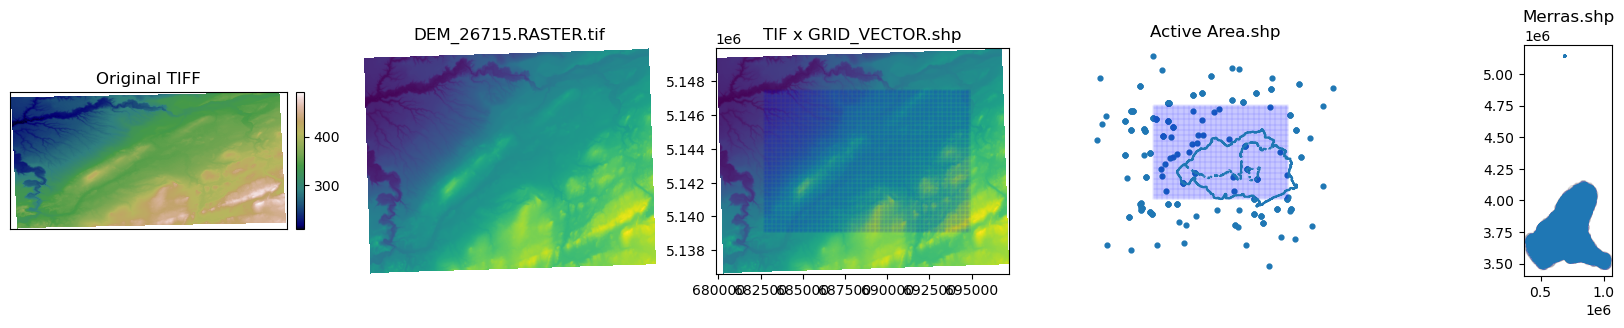

In [ ]:
OVER1=VEC1.to_crs(es.crs_check(R2))                ; OVER2=VEC2.to_crs(es.crs_check(R2))                    ; OVER3=VEC3.to_crs(es.crs_check(R2))
with rio.open(R2) as src:                            ELEV = src.read(1).astype("float")                     ; ELEV[ELEV < 0] = np.nan    
               
fig = plt.figure(figsize=(22,3))                                                         
ax = fig.add_subplot(151)  ; ep.plot_bands(ELEV           , title="Original TIFF" , cmap="gist_earth", ax=ax)  
ax = fig.add_subplot(152)  ; B0.plot(ax=ax)               ; plt.title("DEM_26715.RASTER.tif") ; plt.axis('off')
ax = fig.add_subplot(153)  ; B0.plot(ax=ax)               ; OVER1.boundary.plot(ax=ax, color='b',alpha=0.03 ) ; plt.title("TIF x GRID_VECTOR.shp")
ax = fig.add_subplot(154)  ; plt.title("Active Area.shp") ; OVER1.boundary.plot(ax=ax, color='b',alpha=0.03 )  ; OVER2.boundary.plot(ax=ax); OVER6.boundary.plot(ax=ax,markersize=12) ;plt.axis('off')
ax = fig.add_subplot(155)  ; plt.title("Merras.shp")      ; OVER3.boundary.plot(ax=ax, alpha=0.003)            ; OVER2.boundary.plot(ax=ax)    ; plt.show(block=False)    

In [3]:
%%capture
LNS1 = sfrmaker.Lines.from_nhdplus_v2(NHDPlus_paths=R4, bbox_filter=BOX)
LNS2 = sfrmaker.Lines.from_nhdplus_v2(NHDFlowlines=os.path.join(R5/'NHDFlowline.shp')  , PlusFlowlineVAA=os.path.join(R3/'PlusFlowlineVAA.dbf'),
                                      PlusFlow    =os.path.join(R3/'PlusFlow.dbf')     , elevslope= os.path.join(R3/'elevslope.dbf')        ,bbox_filter=(-90.625, 46.3788, -90.4634, 46.4586))
LNS3 = sfrmaker.Lines.from_shapefile(shapefile=VEB1,id_column='COMID',routing_column=      'tocomid'   ,width1_column='width1'  ,width2_column='width2'  ,
                                     up_elevation_column='elevupsmo',dn_elevation_column= 'elevdnsmo' ,name_column='GNIS_NAME' ,attr_length_units='feet',  attr_height_units='fee  t') # QGIS!!!

In [4]:
%%capture
delr = np.array([250*0.3048] * 160)  ; delc = np.array([250*0.3048] * 111)  
A_GRID = flopy.discretization.StructuredGrid    (delr=delr, delc=delc,xoff=682688, yoff=5139052,  angrot=0,  crs=26715)                    
B_GRID = sfrmaker.StructuredGrid.from_shapefile (shapefile=BOX,icol='i',  jcol='j',  active_area=VEB2)          #plt.imshow(B_GRID.isfr, interpolation='nearest')
m = flopy.modflow.Modflow.load('tf.nam', model_ws=R1/'tylerforks')                                   

In [5]:
%%capture
SFRD = LNS2.to_sfr( grid = A_GRID  ,model = m ,model_length_units='feet')                                                   # XY        # LNS1 # LNS2 # LNS3        # MF6 Instance
SFRD.set_streambed_top_elevations_from_dem(R1/'dem_26715.tif', elevation_units='meters')        ; SFRD.assign_layers()      #  Z
#SFRD.REACH_D.loc[SFRD.REACH_D['rno'] == 1, 'strhc1'] = 5        ; SFRD.REACH_D.to_csv(TA/'01REACH_D.csv')      

In [6]:
%%capture
SFRD.run_diagnostics(verbose=False);SFRD.write_package(version='mf6')         ;SFRD.write_tables()       ;SFRD.write_shapefiles();shutil.move('shps',TA/'shps');shutil.move('tables',TA/'tables')
SFRE=sfrmaker.SFRData.from_tables(TA/'tables/tf_sfr_reach_data.csv',TA/'tables/tf_sfr_segment_data.csv',grid=A_GRID)                                                       # SFRD.write_package()

<font color='blue'> **TA/...** </font> <font color='red'> **.. but still from LNS1|LNS2 _________________________________________________ !** </font>

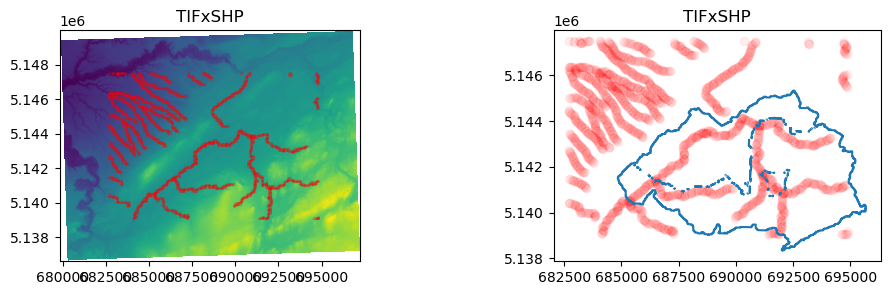

In [ ]:
VEC4 = gpd.read_file(os.path.join(TA/'shps/tf_sfr_cells.shp'))           ; VEC5 = gpd.read_file(os.path.join(TA/'shps/tf_sfr_lines.shp'))  #tf_sfr_cells #lines #outlets #routing    
fig = plt.figure(figsize=(12,3))                                                         
ax = fig.add_subplot(121)  ;OVER4=VEC4.to_crs(es.crs_check(R2)) ;OVER4.boundary.plot(ax=ax,alpha=0.3,color='r')  ;plt.title("TIFxSHP")  ;B0.plot(ax=ax)    
ax = fig.add_subplot(122)  ;OVER5=VEC5.to_crs(es.crs_check(R2)) ;OVER5.boundary.plot(ax=ax,alpha=0.03,color='r') ;plt.title("TIFxSHP")  ;OVER2.boundary.plot(ax=ax) ;plt.show(block=False)

<font color='orange'> **____________________________________________________________________________________________________________________________** </font> 

In [ ]:
%%capture
SFR = LNS2.to_sfr(grid=B_GRID, model=m, model_length_units='feet')          ; DEM = ('E:/15_REPOS/02_Beta-Me/data/sfrmaker/tylerforks/DEM_26715.tif')
RAW = SFR.sample_reach_elevations(R2, method='buffers', smooth=False)       ; SMOO = SFR.sample_reach_elevations(DEM, method='buffers', smooth=True)

In [9]:
import pandas as pd
dfs = []  ; SEG = SFR.reach_data.groupby('iseg')            #NHDPlus elevations  higher than the model top or DEM means the COMID start elevation 'originates' outside of the model domain
for iseg, srd in SEG:
    df = srd.copy()   ; df['dist'] = srd.rchlen.cumsum()       ; df['NHDPlus elevations']=df.strtop     ; dfs.append(df[['i','j','rno','iseg','ireach','dist','NHDPlus elevations']])
n='n'                                                          ; df = pd.concat(dfs)                    ; df['model top'] = SFR.model.dis.top.array[df.i, df.j]
df['raw sampled elevations']       = [RAW [rno] for rno in df['rno'].values]                            ; df['raw sampled elevations']       /= .3048 
df['smoothed sampled elevations']  = [SMOO[rno] for rno in df['rno'].values]                            ; df['smoothed sampled elevations']  /= .3048                                         
SEG = df.groupby('iseg')                                                                                ; df.to_csv(TA/'SFR.csv')           
#os.startfile(TA/'SFR.csv')  ; import xlwings as xw ; wb = xw.Book('E:/15_REPOS/02_Beta-Me/Beta_xls/SFR.xlsx')  ; wb.sheets['SRT'].activate()

In [10]:
#for iseg, srd in SEG:     # iseg == 1:     ___________________________ PLOT Z ___________________________
#    srd = srd.copy()      ; srd.index = srd.dist
#    ax = srd[['model top' ,'NHDPlus elevations' ,'raw sampled elevations' ,'smoothed sampled elevations']].plot()   ; ax.set_xlabel('Distance ft');ax.set_ylabel('Elevation ft')

<font color='orange'> **____________________________________________________________________________________________________________________________** </font> 

In [11]:
from sfrmaker.routing import find_path, get_upsegs, make_graph, make_reverse_graph
routing = make_graph(SFR.segment_data['nseg'], SFR.segment_data['outseg'], one_to_many=False) # one or more downstream connections for each node / single integer downstream connection 
print(routing[1])  ; print(find_path(routing, 1)) #routing_r = make_reverse_graph(routing) ; routing_r[4]   # get_upsegs(routing_r, 42)

4
[1, 4, 6, 8, 10, 11, 0]


Text(0.5, 0, 'Distance in River miles')

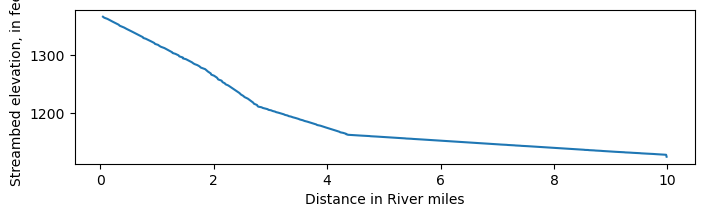

In [ ]:
REACH_D    = pd.DataFrame(m.SFR.reach_data)                                                 ; REACH_D.index = REACH_D['reachID']            # REACH_D.to_csv(TA/'AGAIN.csv')
REACH_R    = make_graph(REACH_D['reachID'], REACH_D['outreach'], one_to_many=False)        ; path = find_path(REACH_R, 10)                 # P_REACH -1 -2 -3 ...
P_REACH  = REACH_D.loc[path[:-1]] ; ELEW = P_REACH['strtop']                               ; DIST = np.cumsum(P_REACH['rchlen'])/5280      
fig = plt.figure(figsize=(8,2))   ; ax = fig.add_subplot(111)   ; plt.plot(DIST, ELEW)     ; plt.ylabel('Streambed elevation, in feet')    ; plt.xlabel('Distance in River miles')

<font color='orange'> **____________________________________________________________________________________________________________________________** </font> 